In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [8]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import pandas as pd
import os
import random
import seaborn as sns

from tqdm import tqdm
from src.data.loaders import get_loader
from joblib import Parallel, delayed
from functools import partial
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MACHO stats

In [3]:
def get_stat(path, on='mag', window=100):
    observations = pd.read_parquet(path)
    observations = observations[(observations['errmag']>0) & (observations['errmag']<1)]
    
    if on == 'mjd':
        observations = observations.groupby('newID').diff().dropna()
        
    observations = observations.sort_values(on)
    observations = observations[on].rolling(window=window, step=window).mean()
    return observations.dropna().tolist()

def calculate_stat(root, on='mag', window=1000, njobs=4):
    lc_paths = os.listdir(root)
    preloaded = partial(get_stat, on=on, window=window)
    var = Parallel(n_jobs=njobs, backend='threading')
    results = var(delayed(preloaded)(os.path.join(root, p)) for p in lc_paths )
    flattened = [item for sublist in results for item in sublist]
    return flattened

In [6]:
%%time
root = './data/raw_parquet/macho/light_curves/'
macho_mjd = calculate_stat(root, on='mjd', njobs=32)
macho_mjd = np.array(macho_mjd)[np.array(macho_mjd)>0]

macho_mag = calculate_stat(root, on='mag', njobs=32)

CPU times: user 24min 25s, sys: 6min 47s, total: 31min 13s
Wall time: 1min 36s


In [17]:
%%time
root = './data/raw_parquet/atlas/light_curves/'
other_mjd = calculate_stat(root, on='mjd', njobs=32)
other_mjd = np.array(other_mjd)[np.array(other_mjd)>0]

other_mag = calculate_stat(root, on='mag', njobs=32)

CPU times: user 6min 23s, sys: 1min 27s, total: 7min 51s
Wall time: 28.4 s


2024-09-02 13:54:03,971 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-02 13:54:05,226 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<timed exec>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


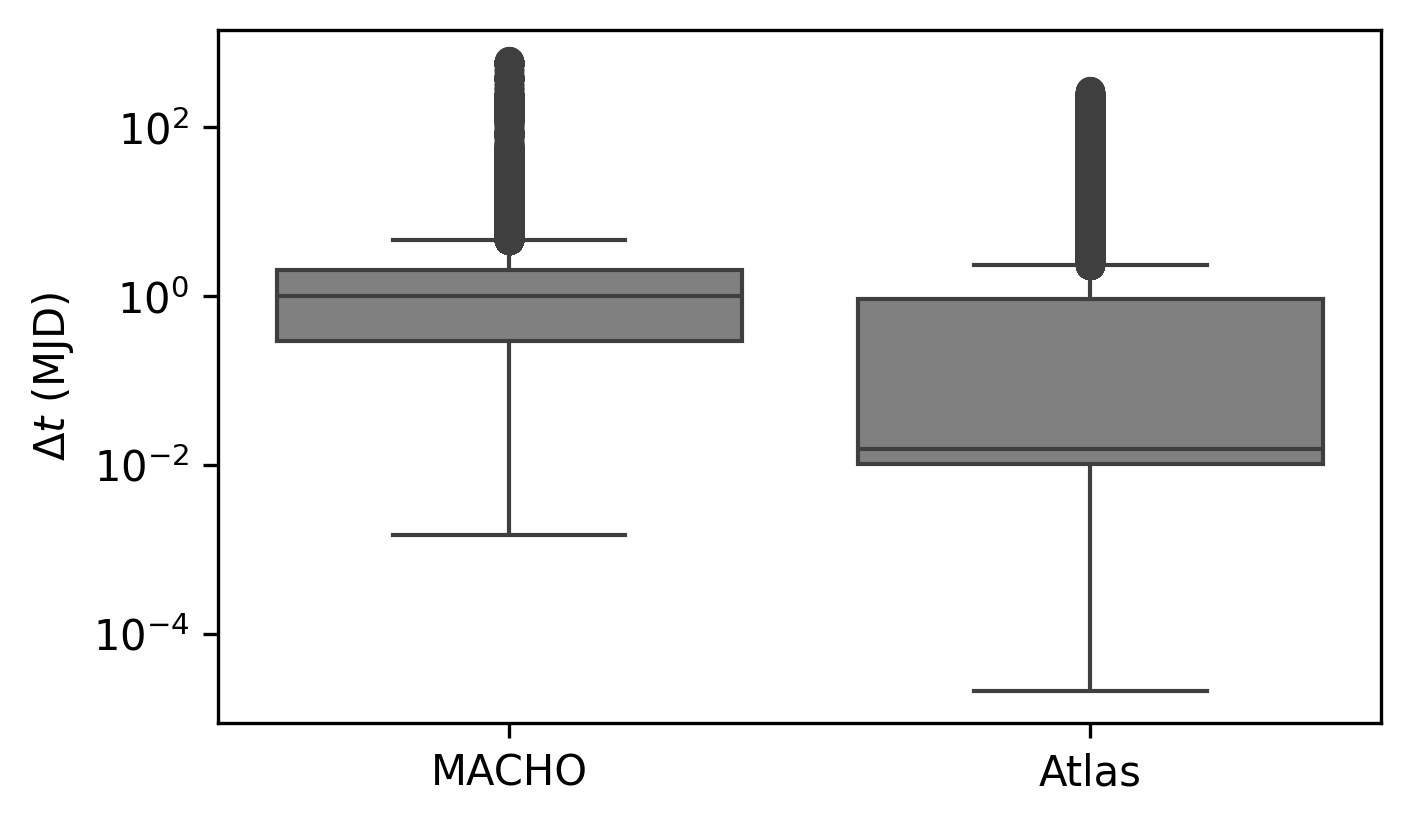

CPU times: user 7.03 s, sys: 614 ms, total: 7.64 s
Wall time: 7.12 s


In [18]:
%%time
NAMEOTHER = 'Atlas'

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5,3))
sns.boxplot(data=[macho_mjd, other_mjd], ax=ax, color='gray')
ax.set_yscale('log')
ax.set_ylabel(r'$\Delta t$ (MJD)')
ax.set_xticklabels(['MACHO', NAMEOTHER])

fig.savefig('./presentation/figures/macho_vs_{}_mjd.pdf'.format(NAMEOTHER), 
            format='pdf', 
            bbox_inches='tight')
plt.show()

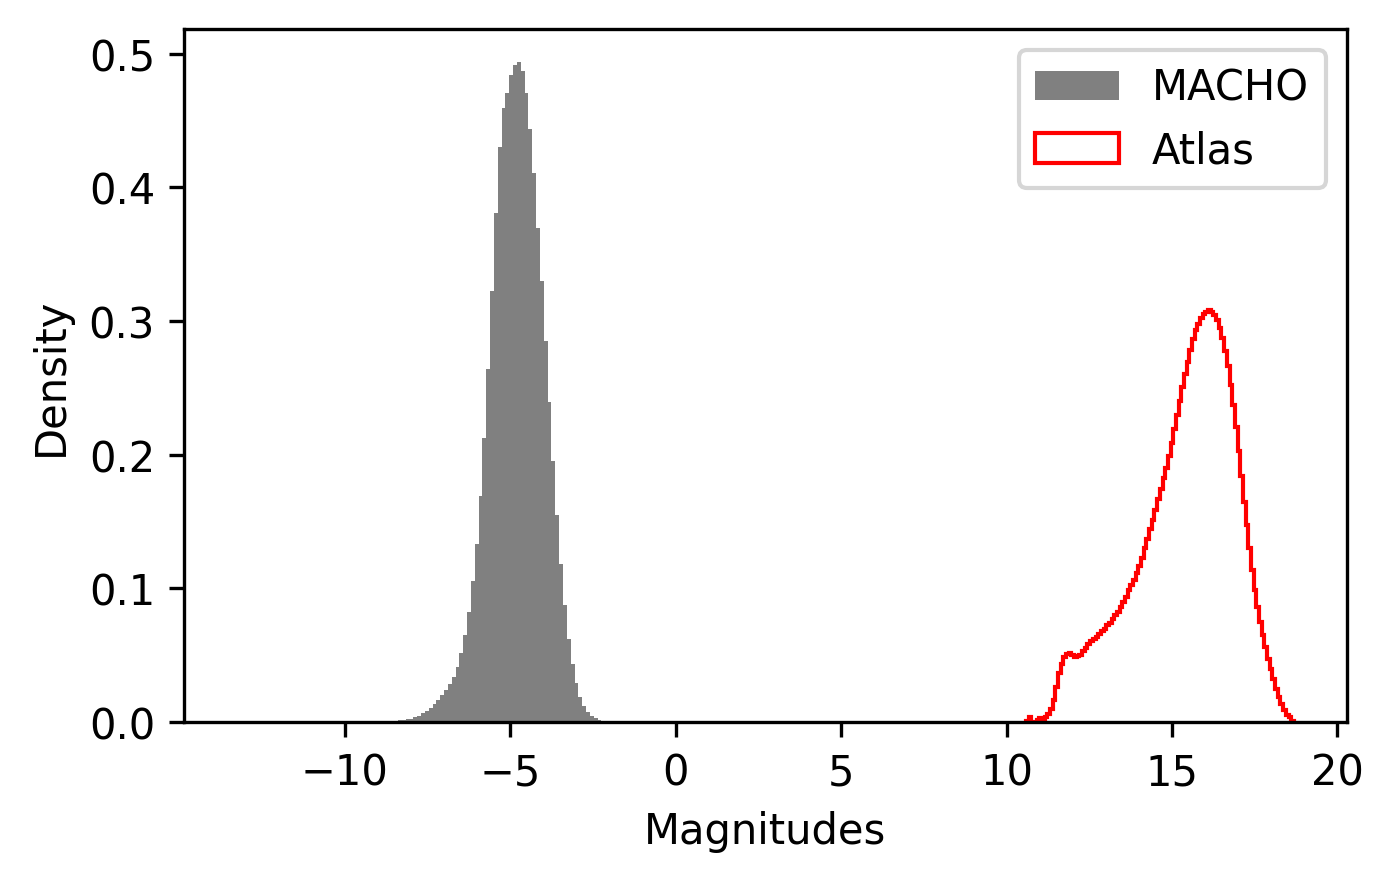

CPU times: user 3.96 s, sys: 473 ms, total: 4.43 s
Wall time: 4.04 s


In [19]:
%%time
plt.figure(figsize=(5, 3), dpi=300)
h1 = plt.hist(macho_mag, bins=100,  density=True, label='MACHO', histtype='stepfilled', color='gray')
h2 = plt.hist(other_mag, bins=100,  density=True, label=NAMEOTHER, histtype='step', color='r')
plt.legend()
plt.xlabel('Magnitudes')
plt.ylabel('Density')
# plt.yscale('log')
plt.savefig('./presentation/figures/macho_vs_{}_mag.pdf'.format(NAMEOTHER), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
scan2 = pl.scan_parquet('./data/raw_parquet/alcock/light_curves/*.parquet')

/tmp/ipykernel_3885663/3473373314.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(xticks, means, stds, fmt='.k', lw=4, color='black')


<ErrorbarContainer object of 3 artists>

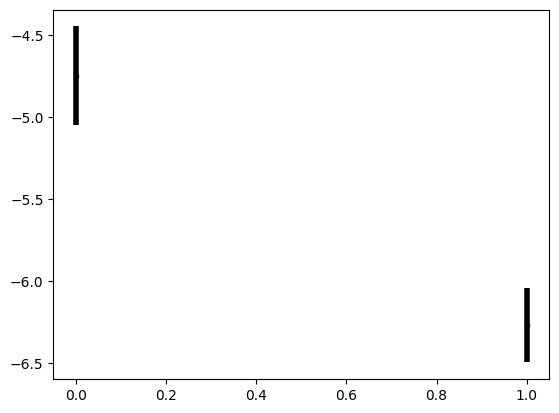

In [51]:
labels = ['MACHO', 'Alcock']
xticks = np.arange(len(labels))

means = np.array([features['mean'].mean(), features2['mean'].mean()])
stds = np.array([features['std'].mean(), features2['std'].mean()])
mins = np.array([features['min'].min(), features2['min'].min()])
maxes = np.array([features['max'].max(), features2['max'].max()])


# plt.errorbar(xticks, means, [means - mins, maxes - means], fmt='.k', ecolor='gray', lw=0.5)
plt.errorbar(xticks, means, stds, fmt='.k', lw=4, color='black')
